In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st


In [3]:
df = pd.read_csv("query_results-2023-09-16_110410.csv")

In [4]:
df

,uid,country,gender,device,group,converted,total_spent
0,1019161,FRA,NaN,I,A,N,NaN
1,1046160,TUR,F,I,B,Y,121.413014
2,1038783,USA,M,I,B,N,NaN
3,1033108,USA,O,A,A,N,NaN
4,1032850,BRA,M,A,B,N,NaN
...,...,...,...,...,...,...,...
48938,1017464,TUR,F,I,B,N,NaN
48939,1014355,CAN,NaN,I,A,N,NaN
48940,1030558,CAN,F,I,B,N,NaN
48941,1009340,BRA,F,I,A,N,NaN


# GlowBox banner A/B test


GlowBox, an e-commerce website, wants to know if adding a banner with key products at the top of the site will increase sales and/or revenue. The test is only run on mobile devices.<sb>
    
    
    -A user who visits the homepage is randomly assigned to a group (A: No banner, B: Banner)
    -Banner is loaded when user is assigned to group A (and not when in group B)
    -When a user in the dataset makes one or more purchases during the runtime of the experiment it's considerd as a conversion.
    
### Questions to be answered:
    1. Does Highlighting key products at the top of the mobile site increase sales
    2. Does highlighting key products at the top of the mobile site increase revenue

## 1. Does Highlighting key products at the top of the mobile site increase sales
H₀: Adding banner with key products does not chance the conversion rate
<br>
Hₐ: Adding banner with key products does chance the conversion rate
<br>
<br>
H₀: P_exp - P_con <= 0
<br>
Hₐ: P_exp - P_con > 0
<br>
α = 0.05

In [5]:
n = len(df['group'])
print('n:', n)

n: 48943


Proportion users which did convert in the control group :

In [6]:
prop_control = len(df[(df['converted']=="Y") & (df['group']=="A")]) / len(df[df["group"]=="A"])
prop_control

0.03923099042845993

Proportion of users which did convert in the experiment group:

In [7]:
prop_experiment = len(df[(df['converted']=="Y") & (df['group']=="B")]) / len(df[df["group"]=="B"])
prop_experiment

0.04630081300813008

### Confidence intervals

In [8]:
#control
σ_con = np.sqrt(prop_control * (1-prop_control) / n)
σ_con

0.0008775640750452727

In [9]:
z = 1.96
m = z * σ_con
print("Confidence interval:")
print(prop_control - m, '-', prop_control + m)


Confidence interval:
0.037510964841371196 - 0.04095101601554866


In [10]:
#experiment

In [11]:
σ_exp = np.sqrt(prop_experiment * (1-prop_experiment) / n)
z = 1.96
m = z * σ_exp
print("Confidence interval:")
print(prop_experiment - m, '-', prop_experiment + m)

Confidence interval:
0.04443910831771945 - 0.04816251769854071


### Hypothesis test wether there is a difference in conversion

H₀: P_exp - P_con <= 0
<br>
Hₐ: P_exp - P_con > 0
<br>
α = 0.05

In [12]:
exp_size= df[df['group'] == "B"]['group'].count()
con_size= df[df['group'] == "A"]['group'].count() 
z = (prop_experiment - prop_control) / np.sqrt(prop_control*(1-prop_control)/exp_size)
z

5.711523123213494

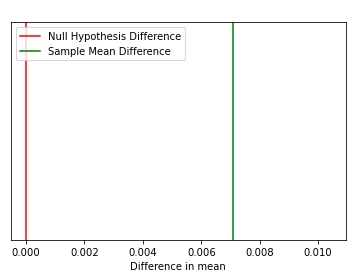

In [72]:
color = "#985277"
exp_plot = np.random.normal(prop_experiment-prop_control, σ_exp, 10000)
plt.hist(exp_plot, color="white")
plt.axvline(0, color="red", label="Null Hypothesis Difference")
plt.axvline(prop_experiment-prop_control, color="green", label="Sample Mean Difference")
plt.legend()
plt.yticks([])
plt.xlabel("Difference in mean")
plt.title("Difference Expected Distribution", color="white")
plt.savefig('plottest', dpi=200, transparent=True)


#### Confidence interval for the dirfference between the conversion rates

In [14]:
z=1.96
diffrence = prop_experiment-prop_control
both_std = σ_exp + σ_con
m= z* both_std
print('confidence interval:')
print( diffrence-m, '-', diffrence+m)


confidence interval:
0.0034880923021707914 - 0.01065155285716952


#### Difference in mean per country

In [15]:
df2 = df.copy()
df2['convertion'] = [ 1 if x == "Y" else 0 for x in df2['converted']]
country_proportions =df2.groupby(['country','group'])['convertion'].mean()
country_proportions

country  group
AUS      A        0.021382
         B        0.030357
BRA      A        0.037253
         B        0.040614
CAN      A        0.046936
         B        0.064757
DEU      A        0.032004
         B        0.044148
ESP      A        0.029087
         B        0.036145
FRA      A        0.031250
         B        0.041828
GBR      A        0.028866
         B        0.036814
MEX      A        0.029485
         B        0.044475
TUR      A        0.040022
         B        0.035582
USA      A        0.051170
         B        0.057484
Name: convertion, dtype: float64

In [16]:
#Confidence level per country
#Z-value to dict
country_zs ={}
for i in range(int(len(country_proportions.index)/2)):
    country = country_proportions.index[i*2][0]
    con_pro = country_proportions.iloc[i*2]
    exp_pro = country_proportions.iloc[i*2+1]
    con_size = df2.query(f'country == "{country}" and group =="B"').shape[0]
    z_val = (exp_pro - con_pro) / np.sqrt(con_pro*(1-con_pro)/ con_size)
    country_zs[country] = z_val

In [64]:
#z to p-value
print("Confidence level per country")
for k in country_zs.keys():
    if country_zs[k] > 0:    
        p_value = st.norm.cdf(country_zs[k])
        print(f"{k}: {p_value*100:.2f}%")
    else: print(f"{k}: 0.00%")

Confidence level per country
AUS: 92.90%
BRA: 88.64%
CAN: 99.15%
DEU: 99.88%
ESP: 90.75%
FRA: 99.17%
GBR: 96.67%
MEX: 100.00%
TUR: 0.00%
USA: 99.33%


### Bootstrap

In [18]:
diffs = []
for _ in range(10000):
    b_samp = df.sample(df.shape[0], replace = True)
    con_df = b_samp.query('group =="A"')
    exp_df = b_samp.query('group == "B"')
    con_cr = len(con_df.query('converted == "Y"')) / len(con_df)
    exp_cr = len(exp_df.query('converted == "Y"')) / len(exp_df)
    diffs.append(exp_cr-con_cr)

(array([   9.,   66.,  439., 1382., 2797., 2874., 1759.,  571.,   93.,
          10.]),
 array([-0.00030993,  0.00113143,  0.00257279,  0.00401414,  0.0054555 ,
         0.00689686,  0.00833822,  0.00977958,  0.01122094,  0.0126623 ,
         0.01410366]),
 <BarContainer object of 10 artists>)

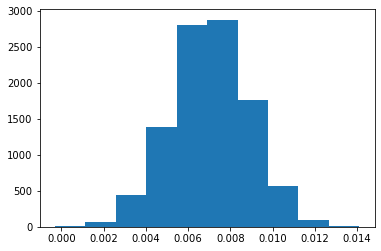

In [19]:
plt.hist(diffs)

In [20]:
diffs = np.array(diffs)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

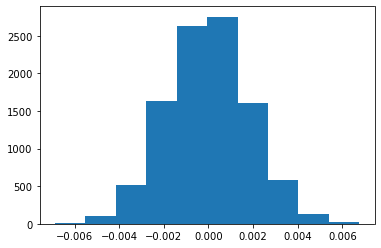

In [21]:
plt.hist(null_vals);

In [60]:
#p-value
(null_vals > diffs).mean()

ValueError: operands could not be broadcast together with shapes (10000,) (1000,) 

Since the p-value is smaller then alpha we are condifent that experiment did signifecantly increase the ammount of sales

# 2. Does Highlighting key products at the top of the mobile site increase revenue

H₀: Adding banner with key products does not increase mean revenue per customer<br>
Hₐ: Adding banner with key products does increase mean revenue per customer<br>

H₀: u_exp - u_con <= 0
<br>
Hₐ: u_exp - u_con > 0
<br>
α = 0.05

In [23]:
#mean spent in control
print('Control group spent mean, total, and count')
spent_mean_con = df[df['group']=='A']['total_spent'].sum() / df[df['group']=='A']['total_spent'].shape[0]
spent_total_con = df[df['group']=='A']['total_spent'].sum()
spent_count_con = df[df['group']=='A']['total_spent'].count()
print(spent_mean_con)
print(spent_total_con)
print( spent_count_con)

#mean spent in exp
print('Experiment group spent mean, total, and count')
spent_mean_exp = df[df['group']=='B']['total_spent'].sum() / df[df['group']=='B']['total_spent'].shape[0]
spent_total_exp = df[df['group']=='B']['total_spent'].sum()
spent_count_exp = df[df['group']=='B']['total_spent'].count()
print(spent_mean_exp)
print(spent_total_exp)
print(spent_count_exp)

Control group spent mean, total, and count
3.374518467928841
82145.90306479178
955
Experiment group spent mean, total, and count
3.3908669458857834
83415.32686879027
1139


In [24]:
#FIll missing value with 0 in spent column
rev_df = df.copy()
rev_df['total_spent'] = rev_df['total_spent'].fillna(0)


In [25]:
diffs = []
for _ in range(1000):
    b_sample = rev_df.sample(rev_df.shape[0], replace=True)
    con_df = b_sample.query('group == "A"')
    exp_df = b_sample.query('group == "B"')
    con_spent_mean = con_df['total_spent'].mean()
    exp_spent_mean = exp_df['total_spent'].mean()
    diffs.append(exp_spent_mean - con_spent_mean)    
    

(array([ 18.,  35., 118., 216., 245., 204., 111.,  39.,  10.,   4.]),
 array([-0.64465641, -0.49965944, -0.35466247, -0.20966551, -0.06466854,
         0.08032843,  0.2253254 ,  0.37032236,  0.51531933,  0.6603163 ,
         0.80531326]),
 <BarContainer object of 10 artists>)

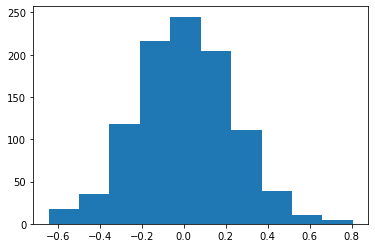

In [26]:
plt.hist(diffs)

In [27]:
diffs = np.array(diffs)
null_valls = np.random.normal(0, diffs.std(), diffs.size)

In [61]:
#p-value
(null_valls >= diffs).mean()

0.502

We fail te reject the Null hypothesis since there is not significantly more spent on average per customer

## 2. Z-statistic

H₀: Adding banner with key products does not increase mean revenue per customer<br>
Hₐ: Adding banner with key products does increase mean revenue per customer<br>

H₀: u_exp - u_con <= 0
<br>
Hₐ: u_exp - u_con > 0
<br>
α = 0.05

In [66]:
con_mean = rev_df.query('group == "A"')['total_spent'].mean()
exp_mean = rev_df.query('group == "B"')['total_spent'].mean()
con_std = rev_df.query('group == "A"')['total_spent'].std()
exp_std = rev_df.query('group == "A"')['total_spent'].std()
con_size = rev_df.query('group == "A"')['total_spent'].shape[0]
exp_size = rev_df.query('group == "B"')['total_spent'].shape[0]
t = (exp_mean-con_mean) / np.sqrt((con_std**2/con_size) + (exp_std**2/exp_size)) 
print(t)


0.06972316589752209


In [67]:
sample_std = rev_df['total_spent'].std() 
sample_size = rev_df['total_spent'].shape[0]
z= (exp_mean-con_mean)/ (sample_std/ np.sqrt(sample_size))
z

0.14086823849734045

Fail to reject the null hypothesis since the z of 0.141 comes no were close to the z of 1.96 which is needed to reject the null hypothesis.

In [68]:
print(con_mean, exp_mean)

3.3745184679288442 3.390866945885785


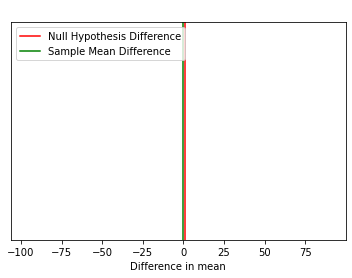

In [74]:
color = "#985277"
exp_plot = np.random.normal(exp_mean-con_mean, con_std, 10000)
plt.hist(exp_plot, color="white")
plt.axvline(1, color="red", label="Null Hypothesis Difference")
plt.axvline(prop_experiment-prop_control, color="green", label="Sample Mean Difference")
plt.legend()
plt.yticks([])
plt.xlabel("Difference in mean")
plt.title("Difference Expected Distribution", color="White")
plt.savefig('plottest2', dpi=200, transparent=True)

## Confidence interval average ammount spent per group

 a = 0.05
 

### Control GROUP

In [32]:
con_mean = rev_df.query('group == "A"')['total_spent'].mean()
print('Mean Control: ',con_mean)
con_std = rev_df.query('group == "A"')['total_spent'].std()
print("Standard Deviation: ", con_std)
sample_size = rev_df.query('group == "A"')['total_spent'].count()
print('Sample group size: ', sample_size)
con_standard_error = con_std / np.sqrt(sample_size)
print("SE: ", con_standard_error)
z= 1.96
print('Z for 95% confidence interval', z)
m = z*con_standard_error
print("margin of error: ",m)
print(con_mean - m, " - ", con_mean+m)

Mean Control:  3.3745184679288442
Standard Deviation:  25.936390557227377
Sample group size:  24343
SE:  0.1662350076525923
Z for 95% confidence interval 1.96
margin of error:  0.3258206149990809
3.0486978529297635  -  3.700339082927925


### Treatment Group

In [33]:
exp_mean = rev_df.query('group == "B"')['total_spent'].mean()
print('Mean Control: ',exp_mean)
exp_std = rev_df.query('group == "B"')['total_spent'].std()
print("Standard Deviation: ", exp_std)
sample_size = rev_df.query('group == "B"')['total_spent'].count()
print('Sample group size: ', sample_size)
exp_standard_error = exp_std / np.sqrt(sample_size)
print("SE: ", exp_standard_error)
z= 1.96
print('Z for 95% confidence interval', z)
m = z*exp_standard_error
print("margin of error: ",m)
print(exp_mean - m, " - ", exp_mean+m)

Mean Control:  3.390866945885785
Standard Deviation:  25.41410959922202
Sample group size:  24600
SE:  0.1620344446370341
Z for 95% confidence interval 1.96
margin of error:  0.3175875114885868
3.0732794343971985  -  3.708454457374372


# Revenue per country
## Is there a significant change in reveneu per country?

H₀: u_exp - u_con = 0 <br>
Hₐ: u_exp - u_con <> 0 <br>
α = 0.05

In [34]:
rev_df

,uid,country,gender,device,group,converted,total_spent
0,1019161,FRA,NaN,I,A,N,0.000000
1,1046160,TUR,F,I,B,Y,121.413014
2,1038783,USA,M,I,B,N,0.000000
3,1033108,USA,O,A,A,N,0.000000
4,1032850,BRA,M,A,B,N,0.000000
...,...,...,...,...,...,...,...
48938,1017464,TUR,F,I,B,N,0.000000
48939,1014355,CAN,NaN,I,A,N,0.000000
48940,1030558,CAN,F,I,B,N,0.000000
48941,1009340,BRA,F,I,A,N,0.000000


In [35]:
# dictonary {country: {group A: [mean:x, std:x, size:x], group B: [mean:x, std:x, size:x]}}
c_dict = {}
for c in rev_df['country'].unique():
    con = rev_df.query(f'country == "{c}" and group == "A"')
    exp = rev_df.query(f'country == "{c}" and group == "B"')
    con_mean = con['total_spent'].mean()
    exp_mean = exp['total_spent'].mean()
    con_std = con['total_spent'].std()
    exp_std = exp['total_spent'].std()
    con_size = con.shape[0]
    exp_size = exp.shape[0]
    to_add = {"A":[con_mean, con_std, con_size] , "B": [exp_mean, exp_std, exp_size]}
    c_dict[c] = to_add

In [36]:
c_z_dict = {}
for c in rev_df['country'].unique()[:-1]:
    con = rev_df.query(f'country == "{c}" and group == "A"')
    exp = rev_df.query(f'country == "{c}" and group == "B"')
    con_mean = con['total_spent'].mean()
    exp_mean = exp['total_spent'].mean()
    diff_mean =  exp_mean - con_mean
    
    con_std = con['total_spent'].std()
    exp_std = exp['total_spent'].std()

    con_size = con.shape[0]
    exp_size = exp.shape[0]
                         
    denominator = np.sqrt(con_std**2/con_size + exp_std**2/exp_size)
    z = diff_mean /denominator
    c_z_dict[c]= z
    

In [63]:
c_z_dict

{'FRA': -0.721786915265957,
 'TUR': -1.644674516058606,
 'USA': -0.5626096803441875,
 'BRA': -0.26401221022622706,
 'MEX': 0.8482683070172029,
 'DEU': -0.6772396938847064,
 'AUS': 0.5195974862245274,
 'ESP': 1.324078104091344,
 'GBR': 1.7884955568158325,
 'CAN': 0.6181678924998831}

In [65]:
#z to p-value
print("Confidence level per country")
for k in c_z_dict.keys():
    if c_z_dict[k] > 0:    
        p_value = st.norm.cdf(c_z_dict[k])
        print(f"{k}: {p_value*100:.2f}%")
    else: print(f"{k}: 0.00%")

Confidence level per country
FRA: 0.00%
TUR: 0.00%
USA: 0.00%
BRA: 0.00%
MEX: 80.19%
DEU: 0.00%
AUS: 69.83%
ESP: 90.73%
GBR: 96.32%
CAN: 73.18%
